# Testing QPTE with quantumaudio

In [1]:
import quantumaudio as qa
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.visualization import plot_histogram
import qiskit

In [2]:
qiskit.__version__ #please use < 2.0

'1.4.0'

In [3]:
sqpam1 = qa.load_scheme('sqpam')
sqpam2 = qa.load_scheme('sqpam')

Single-Qubit Probability Amplitude Modulation
Single-Qubit Probability Amplitude Modulation


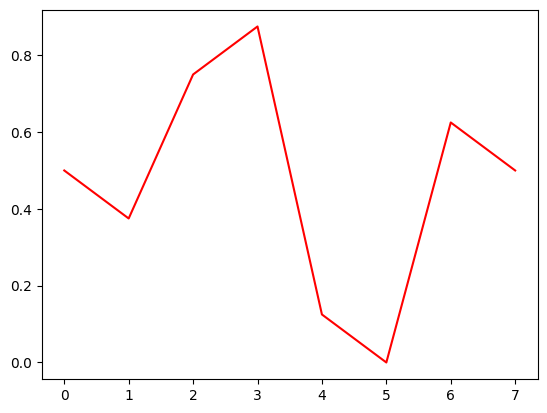

In [4]:
test_signal_1 = (np.array([0., -0.25, 0.5, 0.75, -0.75, -1, 0.25, 0.])+1)/2
test_signal_2 = np.array([1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0])
plt.plot(test_signal_1, color='red')
plt.show()

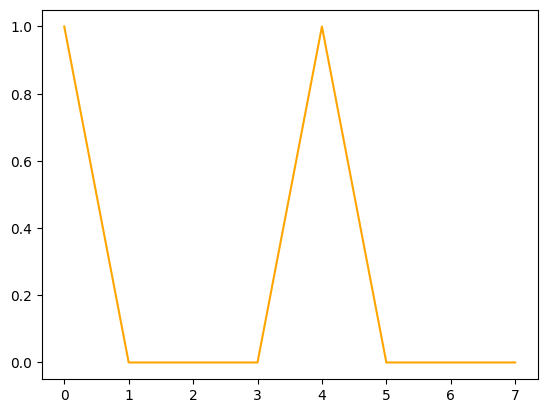

In [5]:
plt.plot(test_signal_2, color='orange')
plt.show()

In [6]:
def convert_to_angles_variant(array: np.ndarray) -> np.ndarray:
    array = array
    norm = np.linalg.norm(array)
    return np.arccos(array/norm)

In [7]:
sqpam1.convert = convert_to_angles_variant
sqpam2.convert = convert_to_angles_variant

In [8]:
circuit1 = sqpam1.encode(test_signal_1, measure=False)
circuit2 = sqpam2.encode(test_signal_2, measure=False)

Number of qubits required: 4

3 qubits for time
1 qubits for amplitude
Number of qubits required: 4

3 qubits for time
1 qubits for amplitude


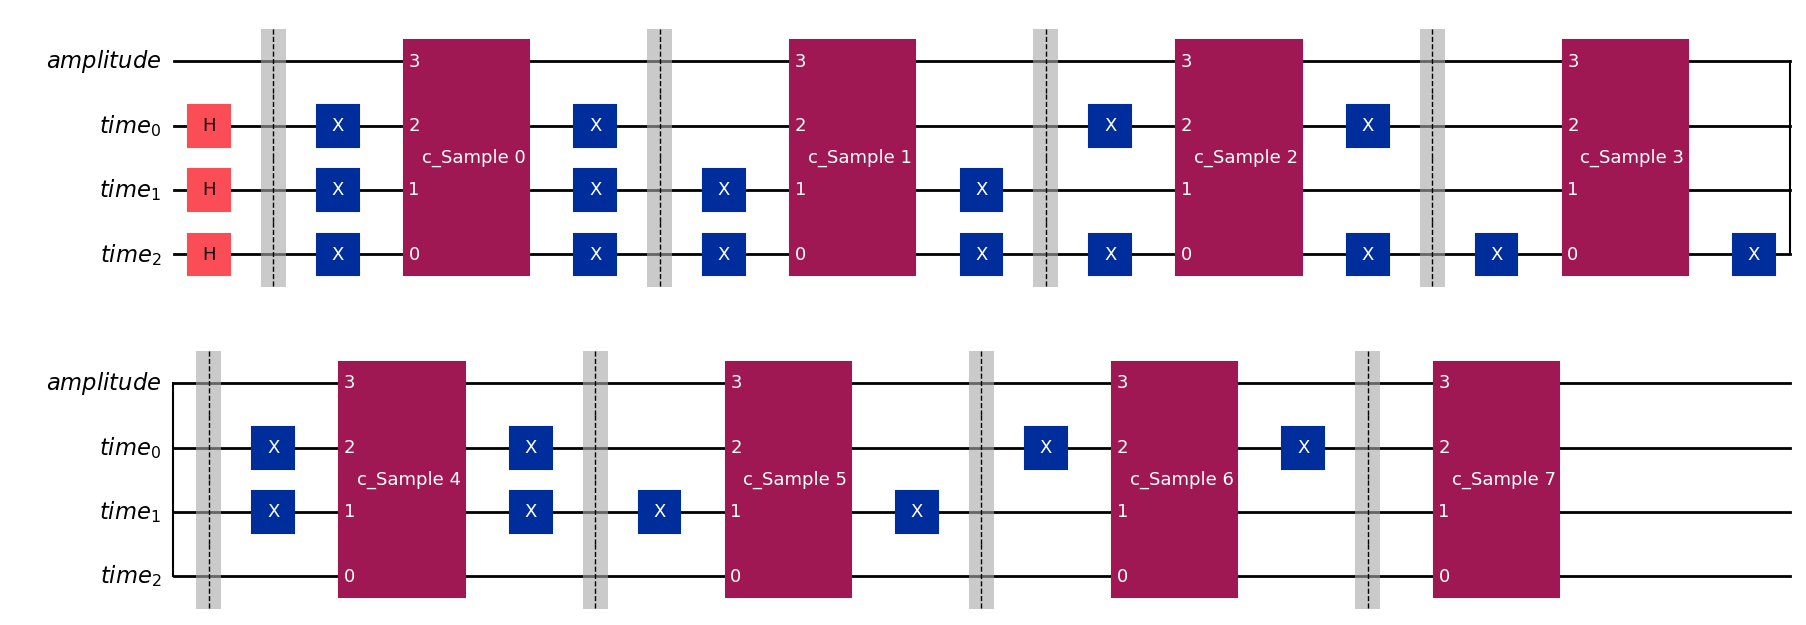

In [9]:
circuit1.draw('mpl')

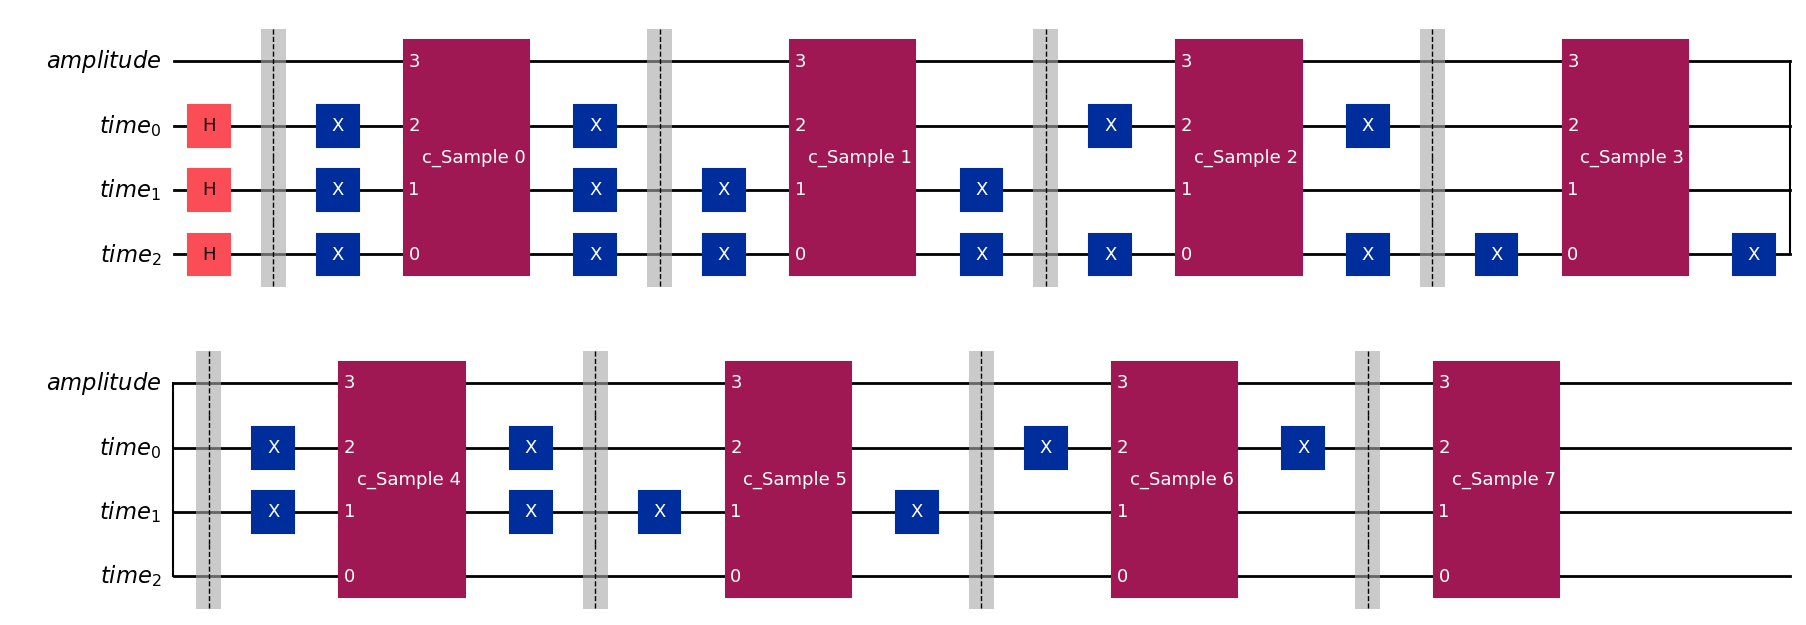

In [10]:
circuit2.draw('mpl')

In [11]:
for i in range(circuit2.metadata['qubit_shape'][0]):
    circuit2.data.pop(0)

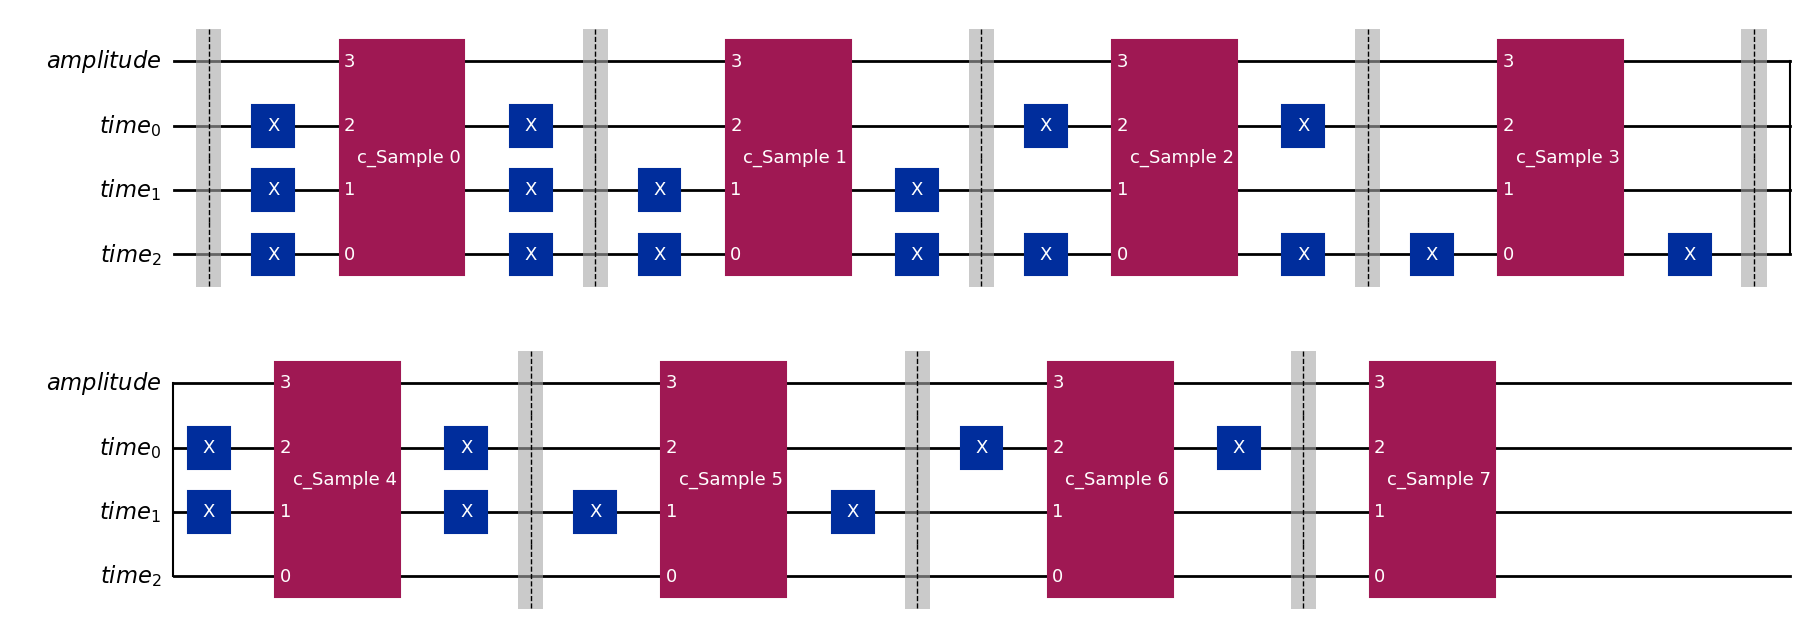

In [12]:
circuit2.draw('mpl')

In [13]:
ar = QuantumRegister(2, name='amplitude')

qpte = QuantumCircuit()
qpte.add_register(ar)
qpte.add_register(circuit1.qregs[1])
qpte.compose(circuit1, qubits=[0, 2, 3, 4],inplace=True)
qpte.compose(circuit2, qubits=[1, 2, 3, 4],inplace=True)
qpte.metadata = circuit1.metadata
qpte.metadata['qubit_shape'] = (circuit1.metadata['qubit_shape'][0], circuit1.metadata['qubit_shape'][1]+1)
qpte.measure_all()

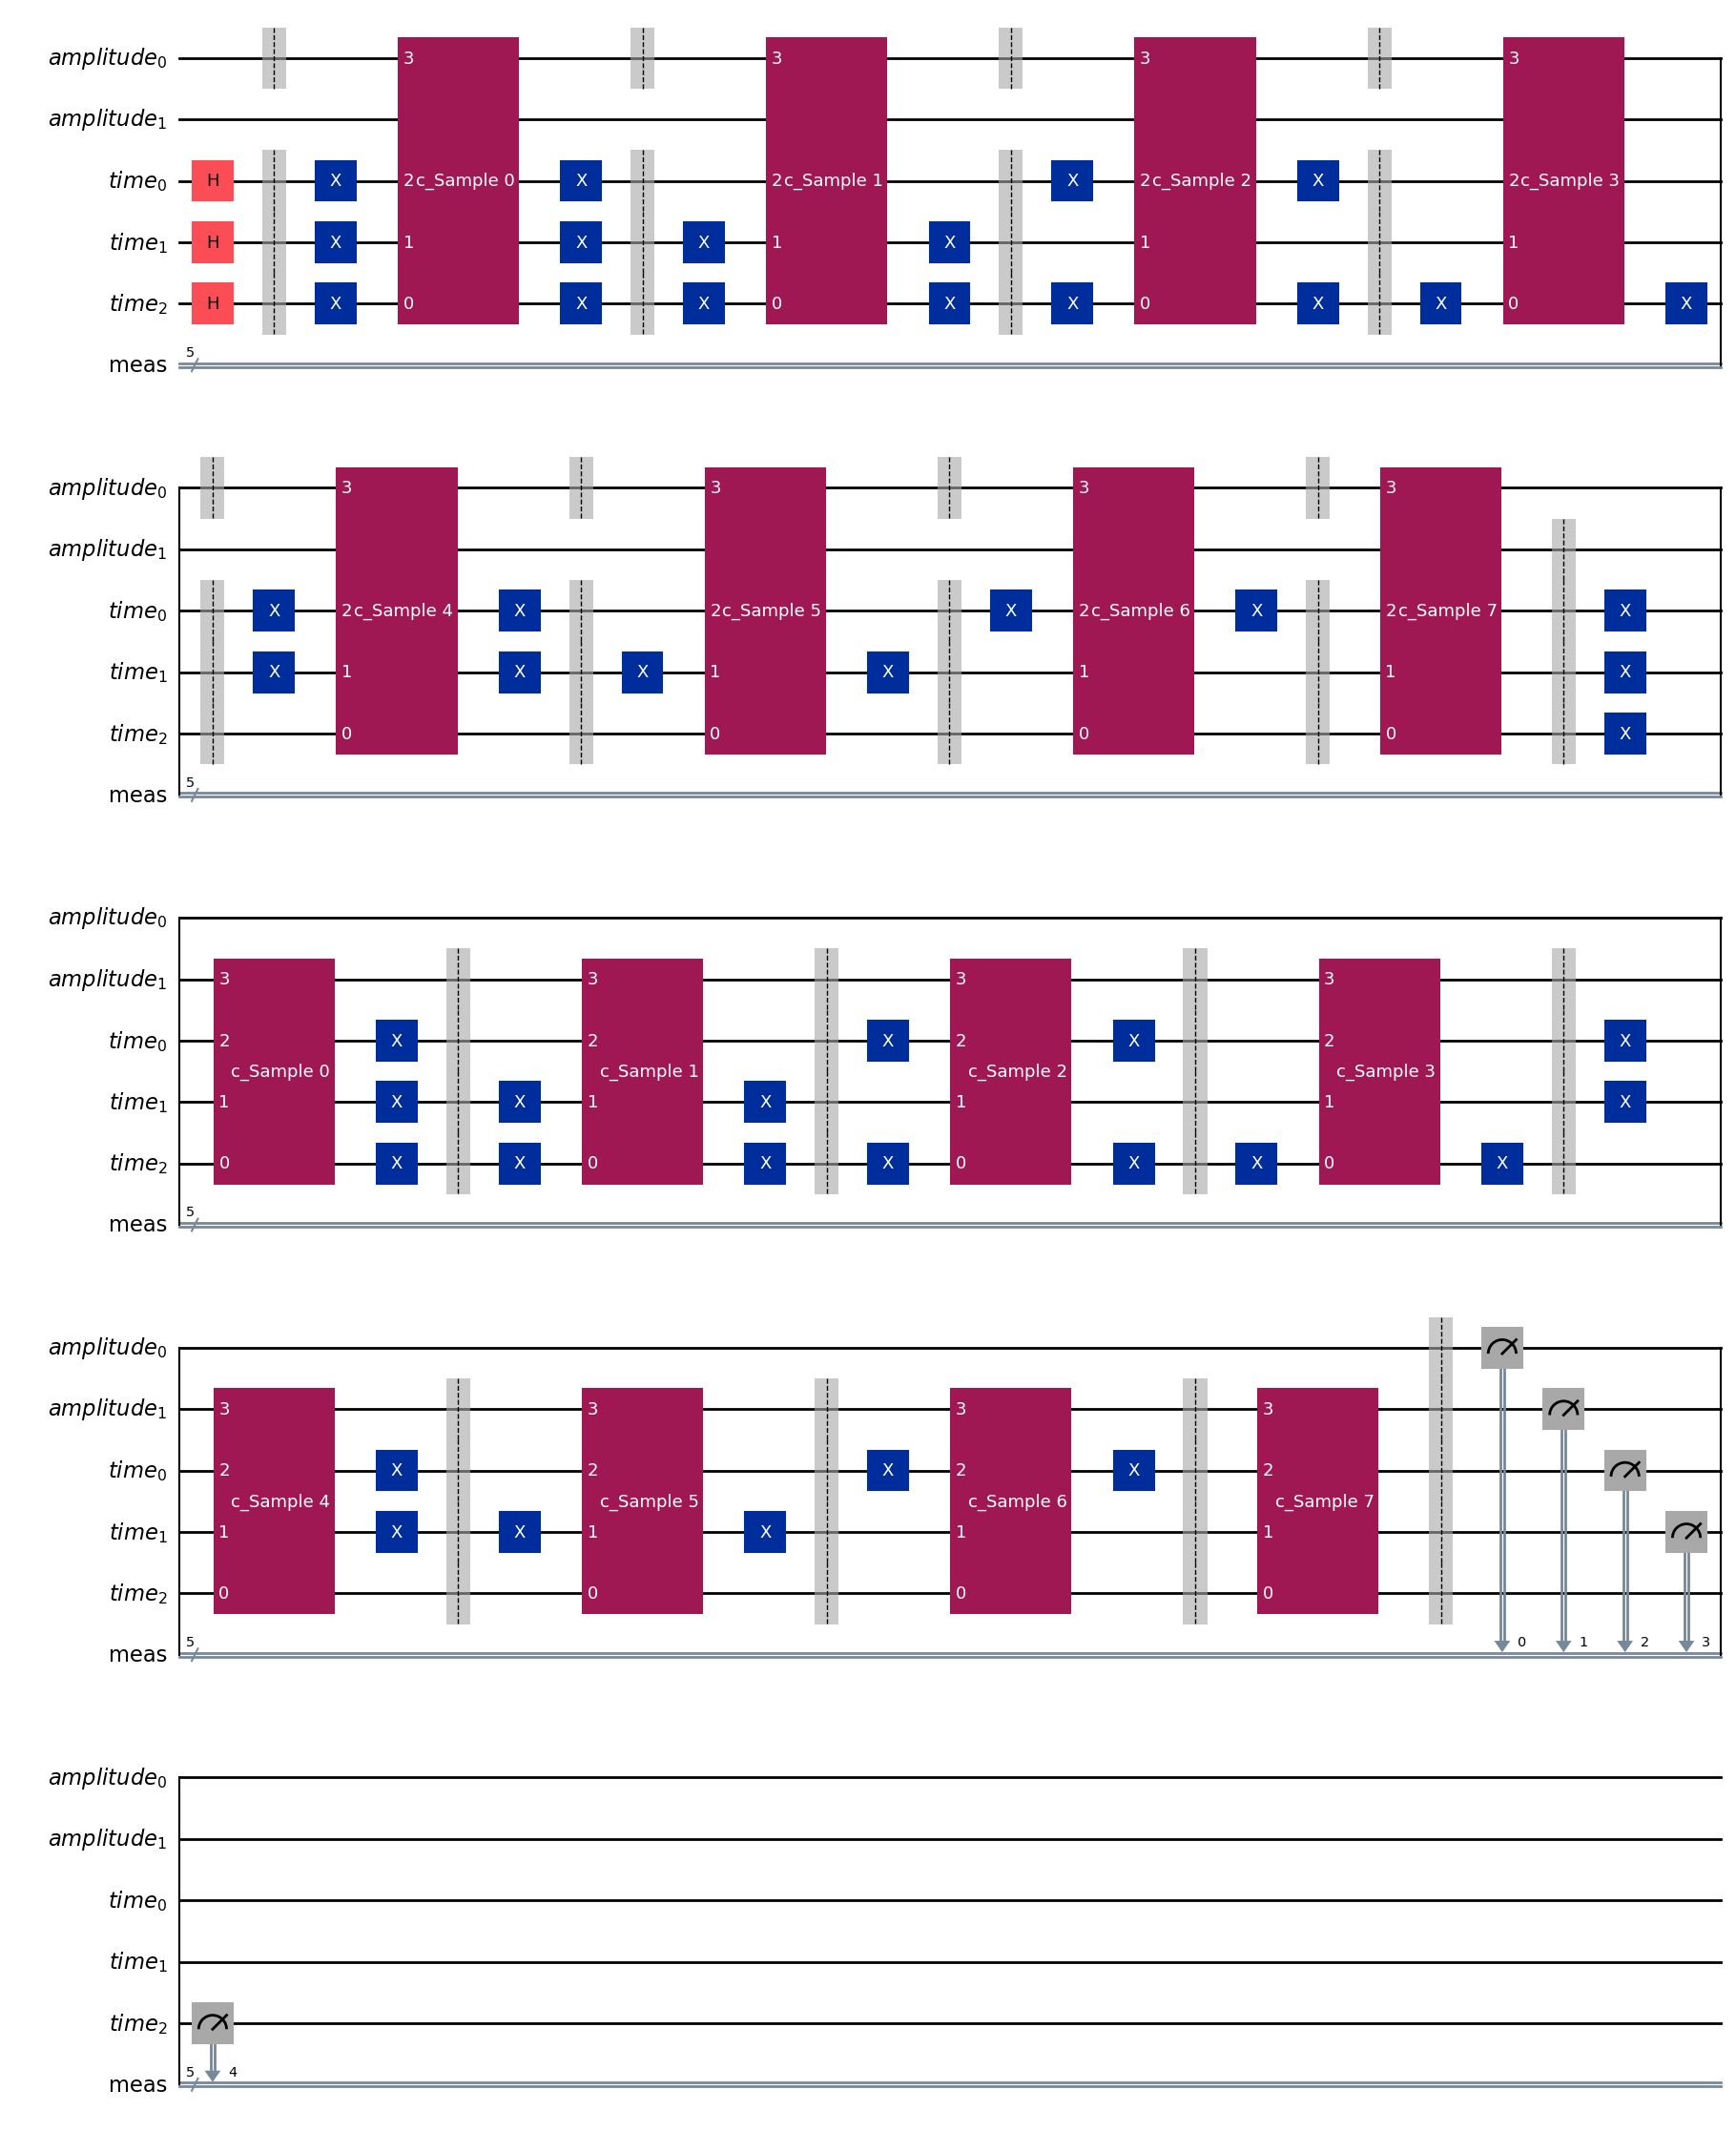

In [14]:
qpte.draw('mpl')

In [15]:
counts = qa.utils.execute(qpte, shots=1000000).get_counts()

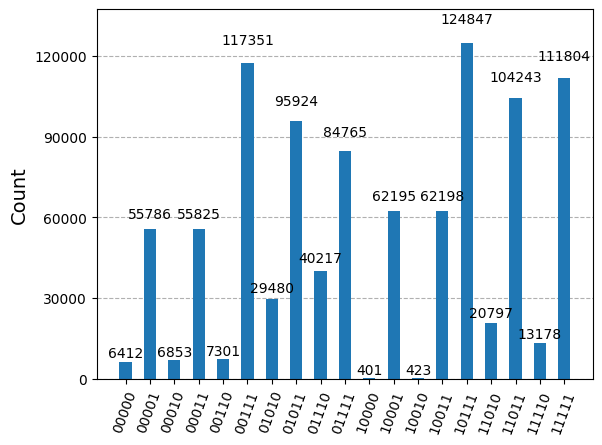

In [16]:
plot_histogram(counts)

In [17]:
qpte.metadata['qubit_shape']

(3, 2)

In [18]:
num_index_qubits = qpte.metadata['qubit_shape'][0]
num_components = 2**num_index_qubits
counts_00 = np.zeros(num_components)
counts_01 = np.zeros(num_components)
counts_10 = np.zeros(num_components)
counts_11 = np.zeros(num_components)


for state in counts:
    index_bits, value_bits = qa.utils.split_string(state, qpte.metadata['qubit_shape'])
    
    
    index = int(index_bits, 2)
    value = counts[state]
    if value_bits == "00":
        counts_00[index] = value
    elif value_bits == "01":
        counts_01[index] = value
    elif value_bits == "10":
        counts_10[index] = value
    elif value_bits == "11":
        counts_11[index] = value

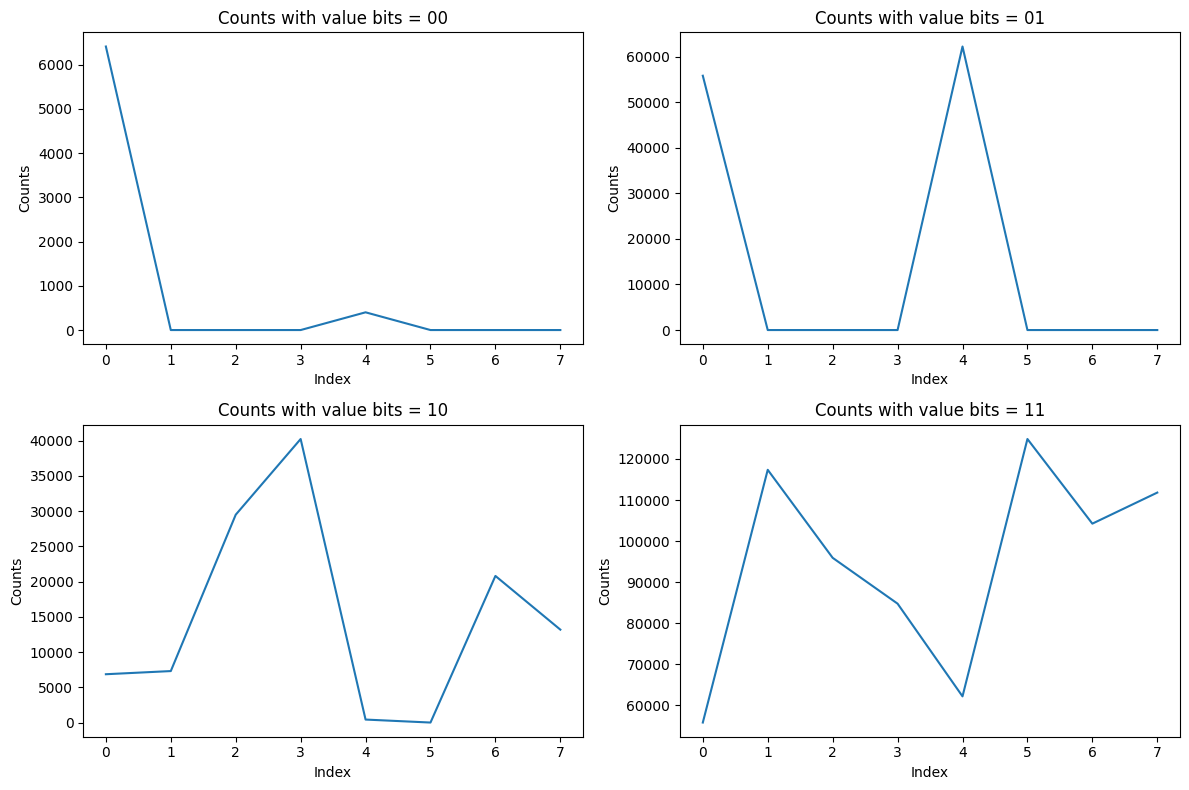

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot for bits == '00'
axs[0, 0].plot(range(num_components), counts_00)
axs[0, 0].set_title("Counts with value bits = 00")
axs[0, 0].set_xlabel("Index")
axs[0, 0].set_ylabel("Counts")

# Plot for bits == '01'
axs[0, 1].plot(range(num_components), counts_01)
axs[0, 1].set_title("Counts with value bits = 01")
axs[0, 1].set_xlabel("Index")
axs[0, 1].set_ylabel("Counts")

# Plot for bits == '10'
axs[1, 0].plot(range(num_components), counts_10)
axs[1, 0].set_title("Counts with value bits = 10")
axs[1, 0].set_xlabel("Index")
axs[1, 0].set_ylabel("Counts")

# Plot for bits == '11'
axs[1, 1].plot(range(num_components), counts_11)
axs[1, 1].set_title("Counts with value bits = 11")
axs[1, 1].set_xlabel("Index")
axs[1, 1].set_ylabel("Counts")

# Set the same y-range for all subplots
# max_count_value = max(counts.values())
# for row in axs:
#     for ax in row:
#         ax.set_ylim([0, max_count_value * 1.1])

plt.tight_layout()
plt.show()

In [20]:
def convert_from_angles(
    amps_00: np.ndarray, amps_01: np.ndarray, amps_10: np.ndarray, amps_11: np.ndarray, which: int = 0
) -> np.ndarray:

    total_amps = amps_00 + amps_01 + amps_10 + amps_11
    all_amps = [amps_00, amps_01, amps_10, amps_11]
    amps = all_amps[which]
    ratio = np.divide(
        amps, total_amps, out=np.zeros_like(amps), where=total_amps != 0
    )
    data = np.sqrt(ratio)
    return data

In [21]:
outs = [None]*4
for i, out in enumerate(outs):
    outs[i] = convert_from_angles(counts_00, counts_01, counts_10, counts_11, i)

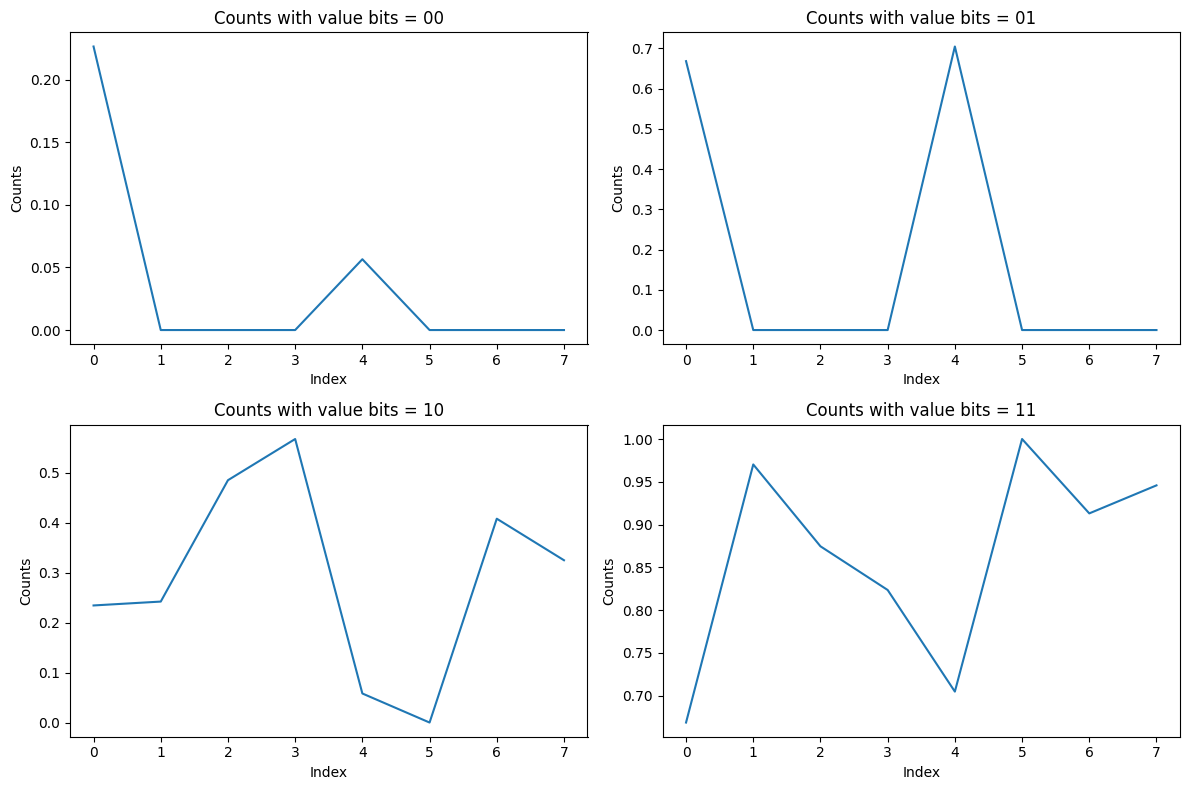

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(range(num_components), outs[0])
axs[0, 0].set_title("Counts with value bits = 00")
axs[0, 0].set_xlabel("Index")
axs[0, 0].set_ylabel("Counts")

axs[0, 1].plot(range(num_components), outs[1])
axs[0, 1].set_title("Counts with value bits = 01")
axs[0, 1].set_xlabel("Index")
axs[0, 1].set_ylabel("Counts")

axs[1, 0].plot(range(num_components), outs[2])
axs[1, 0].set_title("Counts with value bits = 10")
axs[1, 0].set_xlabel("Index")
axs[1, 0].set_ylabel("Counts")

axs[1, 1].plot(range(num_components), outs[3])
axs[1, 1].set_title("Counts with value bits = 11")
axs[1, 1].set_xlabel("Index")
axs[1, 1].set_ylabel("Counts")


# max_count_value = max(counts.values())
# for row in axs:
#     for ax in row:
#         ax.set_ylim([0, max_count_value * 1.1])

plt.tight_layout()
plt.show()

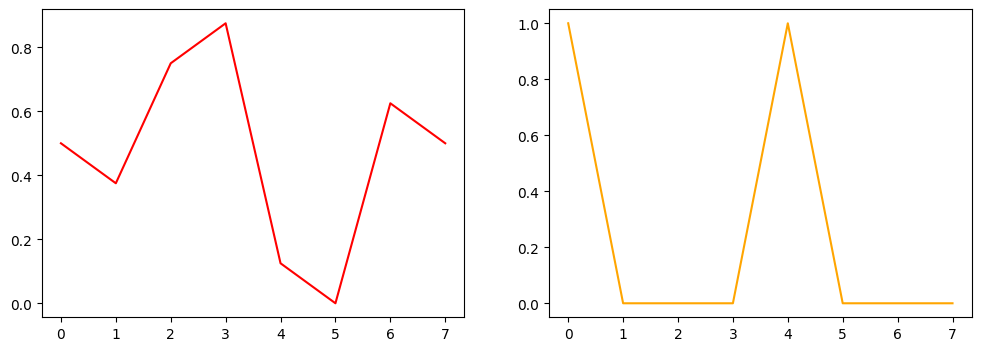

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(test_signal_1, color='red')
axs[1].plot(test_signal_2, color='orange')

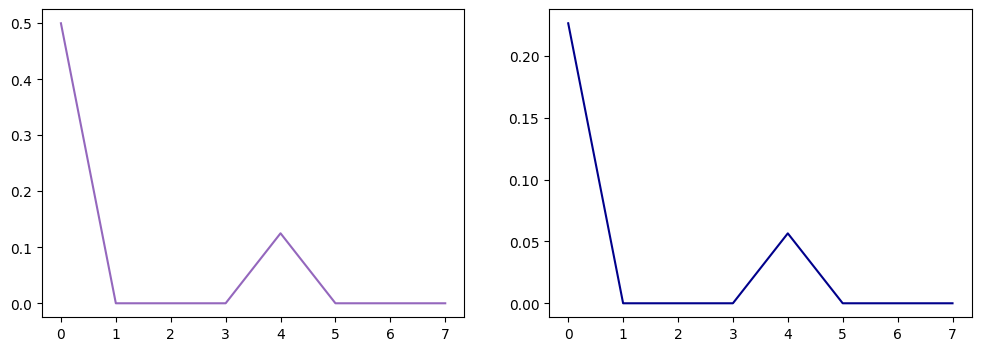

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(test_signal_1*test_signal_2, color='C4')
axs[1].plot(outs[0], color='darkblue')